In [26]:
import pandas as pd
import numpy as np

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
df_players = pd.read_csv(r"/content/drive/My Drive/final_data.csv")
df_players.dropna(inplace=True)

In [29]:
df_players.columns

Index(['player', 'team', 'name', 'position', 'height', 'age', 'appearance',
       'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards',
       'goals conceded', 'clean sheets', 'minutes played', 'days_injured',
       'games_injured', 'award', 'current_value', 'highest_value',
       'position_encoded', 'winger'],
      dtype='object')

# Features:

In [30]:
df_gk = df_players[df_players["position"] == "Goalkeeper"]
df_players = df_players[df_players["position"] != "Goalkeeper"]

In [31]:
gk_cols = [
    'current_value',
    "height",
    "age",
    "appearance",
    "goals conceded",
    "clean sheets",
    "minutes played",
    "award",
    "highest_value",
]
player_cols = [
    'current_value',
    "height",
    "age",
    "appearance",
    "goals",
    "assists",
    "yellow cards",
    "second yellow cards",
    "red cards",
    "minutes played",
    "award",
    "highest_value",
]

In [32]:
df_gk = df_gk.drop(columns = df_gk.columns.difference(gk_cols))
df_players = df_players.drop(columns = df_players.columns.difference(player_cols))

In [33]:
X_gk = df_gk.loc[:,gk_cols[1:]]
X_player = df_players.loc[:,player_cols[1:]]

# Prediction Target

In [34]:
y_gk = df_gk.loc[:,['current_value']]

In [37]:
y_player = df_players.loc[:,['current_value']]

In [40]:
# View top few rows
X_gk.head()

,height,age,appearance,goals conceded,clean sheets,minutes played,award,highest_value
0,189.0,32.0,104,1.217252,0.335463,9390,13,70000000
1,196.0,30.0,15,1.242331,0.207055,1304,1,22000000
2,188.0,37.0,4,0.616438,0.924658,292,4,6000000
32,195.0,30.0,41,0.898502,0.449251,3606,16,17500000
33,190.0,38.0,75,1.331723,0.271780,6623,4,9000000


In [41]:
# Describe columns using basic stats
X_gk.describe()

,height,age,appearance,goals conceded,clean sheets,minutes played,award,highest_value
count,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1.229000e+03
mean,188.827516,27.465487,24.270138,1.152012,0.392717,2167.393816,1.867372,3.278621e+06
std,4.733452,5.618108,24.765288,0.732724,2.710437,2229.872532,3.257837,8.406940e+06
min,172.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,186.000000,23.000000,3.000000,0.842434,0.111111,270.000000,0.000000,2.000000e+05
50%,189.000000,27.000000,16.000000,1.214029,0.255102,1464.000000,1.000000,6.000000e+05
75%,192.000000,32.000000,40.000000,1.534091,0.363066,3562.000000,2.000000,2.250000e+06
max,206.000000,42.000000,105.000000,9.000000,90.000000,9510.000000,36.000000,1.000000e+08


# Decision Tree

In [47]:
import sklearn
from sklearn.model_selection import train_test_split

# Split features and target into training and test sets
X_gk_train, X_gk_test, y_gk_train, y_gk_test = train_test_split(X_gk, y_gk, train_size=0.8, test_size=0.2,random_state=1)
X_player_train, X_player_test, y_player_train, y_player_test = train_test_split(X_player, y_player, train_size=0.8, test_size=0.2,random_state=1)

The data is splitted into training and testing sets for both goalkeeper and players to train the models with the training set and then test the models with the corresponding testing sets. We use random state to ensure each run uses the same random numbers so the models can be used to experiment with different sets of hyperparameters.

In [48]:
# Rebuild model
from sklearn.tree import DecisionTreeRegressor
gk_tree = DecisionTreeRegressor(random_state=1)
player_tree = DecisionTreeRegressor(random_state=1)
gk_tree.fit(X_gk_train, y_gk_train)
player_tree.fit(X_player_train, y_player_train)

DecisionTreeRegressor(random_state=1)

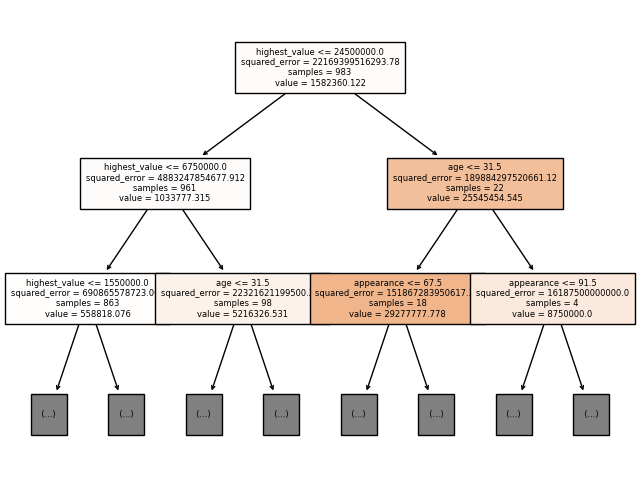

In [49]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6), dpi=100)
plot_tree(gk_tree, max_depth=2, feature_names=X_gk.columns, fontsize= 6, filled=True)
plt.show()

In [52]:
from sklearn.metrics import mean_absolute_error

# Predict test data
y_test_pred = gk_tree.predict(X_gk_test)
y_test_pred_player = player_tree.predict(X_player_test)

# Evaluate test data actual vs prediction
print('MAE (after train-test-split):')
print(mean_absolute_error(y_gk_test, y_test_pred))
print(mean_absolute_error(y_player_test, y_test_pred_player))

MAE (after train-test-split):
902296.7479674796
1391496.062992126


The error numbers are high but the values we are working with are also really high so it is expected. This doesn't mean however they are good. The error for the field players is a lot higher when compared to goalkeepers and this may be the result of poor feature selection. If the features for the field players don't reflect much of the variance in current value then it is expected for the model to perform poorly. Another type of tree model called random forest model can be used to better fit the data.

In [54]:
# Function to build and return MAE for a given number of max_leaf_nodes
def get_mae(mx_lf_nds, X_trn, X_tst, y_trn, y_tst):
    mdlDtrMlbDpt = DecisionTreeRegressor(max_leaf_nodes=mx_lf_nds, random_state=1)
    mdlDtrMlbDpt.fit(X_trn,y_trn)
    y_tst_prd = mdlDtrMlbDpt.predict(X_tst)
    mae = mean_absolute_error(y_tst, y_tst_prd)
    return(mae)

In [55]:
# Iterate over a list of max_leaf_nodes to determine MAE across all
for i in [5, 50, 500, 50000]:
    mae = get_mae(i, X_gk_train, X_gk_test, y_gk_train, y_gk_test)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(i, mae))

Max leaf nodes: 5  		 Mean Absolute Error:  1304885
Max leaf nodes: 50  		 Mean Absolute Error:  871408
Max leaf nodes: 500  		 Mean Absolute Error:  870630
Max leaf nodes: 50000  		 Mean Absolute Error:  870691


After trying different parameters for the max leaf node number, it can be seen that the model performs best with 500 as the parameter so it will be used when predicting.

#Random Forest Model

In [57]:
from sklearn.ensemble import RandomForestRegressor

# Define random forest model
m_gk = RandomForestRegressor(random_state=1)
m_player = RandomForestRegressor(random_state=1)

# Fit model
m_gk.fit(X_gk_train, y_gk_train)
m_player.fit(X_player_train, y_player_train)

# Predict
y_gk_test_pred = m_gk.predict(X_gk_test)
y_player_test_pred = m_player.predict(X_player_test)

# Evaluate
print('MAE (Random Forest):')
print(mean_absolute_error(y_gk_test, y_gk_test_pred))
print(mean_absolute_error(y_player_test, y_player_test_pred))

<ipython-input-57-dda00bc88ad8>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m_gk.fit(X_gk_train, y_gk_train)
<ipython-input-57-dda00bc88ad8>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m_player.fit(X_player_train, y_player_train)


MAE (Random Forest):
644821.7479674796
1032317.8988043162


The Random Forest model performs better than the Decision Tree because it averages multiple trees, reducing overfitting and handling noise better, resulting in lower prediction errors on both training and test data. These errors can be reduced even further if we play with the hyperparameters like we did with the decision tree model.